# **Task 2 - Wind speed prediction**


For task 2, our goal is to predict the wind speed of 13 storm images of surprise storm. Obviously, this might be related to time, so we explored the problem from two dimensions.

In this notebook, we will show two models, CNN-LSTM and CNN. We will start from the following aspects:  

**1. Data processing**  
**2. Construction of model framework**  
**3. Model training and evaluation**  
**4. Presentation of results**

# Import Packages

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, BatchSampler
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import torchvision.transforms as transforms
import os
from PIL import Image, UnidentifiedImageError
from torch.utils.data import ConcatDataset
from torch.utils.data import Dataset, Subset

import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
from IPython.display import Image as pyimage
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import json
from operator import itemgetter
import math
from torchvision.models import resnet101
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
device = 'mps'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on google GPU!")
    device = 'cuda'
else:
    print("M1 GPU")

Cuda installed! Running on google GPU!


# **Model 1   CNN-LSTM**


---

## **Overview**

CNN-LSTM is a class of deep learning models that combines the strengths of Convolutional Neural Networks (CNNs) and Long Short-Term Memory networks (LSTMs).

**1. Convolutional Neural Networks (CNNs):**

- **Purpose**: Selecting features from each storm image.

**2. Long Short-Term Memory Networks (LSTMs):**

- **Purpose**: Using wind speed sequence to solve prediction problems, where context and order of data are crucial.


## **Advantages:**

- **Spatial Feature Learning**: CNNs efficiently process and extract features from image data.
- **Temporal Sequence Modeling**: LSTMs are capable of learning long-term dependencies in sequence data.

## **Disdvantages:**
- **Unbalanced weight**:In the process of training, we find that the final result is more dependent on speed, and the weight allocated to image data is not enough, so some details on the image may be ignored.

# **Model 2   CNN**


---

## **Overview**

*We used CNN as our final model.*

We tried various CNN models, including pytorch's resnet models and multiple self-defined CNNs. Besides of these different architectures, we also tried various strategies to organize input data and output labels.


# CNN_LSTM



## Data Preprocessing



*   **Determine the input data**

   - In the model, we put the image data and velocity series together into the model, so we need to process these two parts separately.  For each storm, we used `_get_storm_sequences` function to make the sequence. In our model, the length of our sequence is 11.

   - At the same time, we process, crop (resize to `[3,128,128]`) and normalize the image in the `__getitem__` function.  

   - **Model Input**: The model takes two inputs:
      - `x_3d`: A tensor representing a batch of image sequences, with the shape `(batch_size, seq_length, C, H, W)`.
      - `scalar_inputs`: A tensor representing additional scalar inputs(wind speed) for each sequence in the batch, with the shape `(batch_size, scalar_input_size)`.
   
      Finally, the input data we get is `Tensor of the current image and the first 9 images of (3,128,128)` + `Known speed of the first 9 images of the current image` in a storm image sequence, with the goal of predicting the current image. That is to say, the dimensions of the input model are `(batch size, 10,3,128,128)`+`(batch size, 9)`.

*   **How to split the data**

    - We move each storm sequence window to get the data set, and divide the data set into 0.7, 0.15, 0.15 to get the training set, test set and verification set, and finally merge 30 storms together.

*   **Data Transformation**
    - We convert the data to 3 channels, and then crop to 128(H*W) with normalization. This is inspired by the link [`Data Transformation`](https://drivendata.co/blog/predict-wind-speeds-benchmark/)




In [4]:
class StormDatasetCNNLSTM(Dataset):
    """
    A dataset class for processing storm image sequences with CNN-LSTM architecture.

    Args:
        root (str): Directory path for the dataset.
        transform (bool): Flag to apply the predefined transforms to the images.
        sequence_length (int): Number of images in each sequence.
    """

    def __init__(self, root, transform=True, sequence_length=5):
        self.transform = transform
        self.root = root
        self.sequence_length = sequence_length
        self.data = self._get_all_storm_sequences()

    def _get_all_storm_sequences(self):
        """Retrieve all storm sequences from the dataset."""
        return self._get_storm_sequences(self.root)

    def _get_storm_sequences(self, storm_path):
        """Get sequences of storm images along with their labels."""
        paths_labels = self._get_image_paths(storm_path)
        sequences = []
        for i in range(len(paths_labels) - self.sequence_length):
            sequence = [path for path, _, _ in paths_labels[i:i + self.sequence_length]]
            label = paths_labels[i + self.sequence_length - 1][2]
            sequences.append((sequence, label))
        return sequences

    def _get_image_paths(self, storm_path, exts=(".jpg")):
        """Retrieve image paths and their labels."""
        data = []
        for root, dirs, files in os.walk(storm_path):
            for file in files:
                if file.endswith(exts):
                    img_path = os.path.join(root, file)
                    num_path = img_path.removesuffix('.jpg')
                    try:
                        label_path = num_path + "_label.json"
                        features_path = num_path + "_features.json"
                        time_feature, label = None, None
                        if os.path.exists(features_path) and os.path.exists(label_path):
                            with open(features_path, 'r') as f:
                                features = json.load(f)
                                time_feature = int(features.get('relative_time'))
                            with open(label_path, 'r') as f:
                                label_data = json.load(f)
                                label = int(label_data['wind_speed'])
                            data.append((img_path, time_feature, label))
                    except UnidentifiedImageError:
                        print(f'Image loading error at {img_path}')
                        pass

        data.sort(key=lambda x: x[1])
        return data

    def __getitem__(self, idx):
        """Returns a single storm image sequence and its label."""
        sequence_paths, final_label = self.data[idx]
        images, labels = [], []

        for img_path in sequence_paths[:-1]:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self._apply_transforms(img)
            images.append(img)

            num_path = img_path.removesuffix('.jpg')
            label_path = num_path + "_label.json"
            with open(label_path, 'r') as f:
                label_data = json.load(f)
                label = int(label_data['wind_speed'])
            labels.append(label)

        labels_tensor = torch.tensor(labels[:-1], dtype=torch.int)

        # Process the last image
        target_img_path = sequence_paths[-1]
        target_img = Image.open(target_img_path).convert('RGB')
        if self.transform:
            target_img = self._apply_transforms(target_img)

        return torch.stack(images), labels_tensor, final_label

    def _apply_transforms(self, img):
        """Apply predefined transformations to the image."""
        transform = transforms.Compose([
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])
        return transform(img)

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.data)

    def __str__(self):
        """Returns a string representation of the dataset object."""
        class_info = self.__class__.__name__
        class_info += f"\n\tLength: {self.__len__()}"
        for key, value in self.__dict__.items():
            class_info += f"\n\t{key}: {value}"
        return class_info


In [5]:
from torch.utils.data import ConcatDataset, Subset
from torchvision import transforms

def seq_dataset(storm_list, sequence_length=11):
    """
    Creates concatenated training, validation, and testing datasets from a list of storms.

    Args:
        storm_list (list of str): List of storm identifiers or paths.
        sequence_length (int): The length of the sequence for each sample.

    Returns:
        tuple: A tuple containing concatenated training, testing, and validation datasets.
    """
    storm_train_datasets = []
    storm_test_datasets = []
    storm_val_datasets = []

    for storm in storm_list:
        storm_path = f'/content/gdrive/MyDrive/Selected_Storms_curated/{storm}'
        print(storm_path)

        storm_dataset = StormDatasetCNNLSTM(storm_path, sequence_length=sequence_length)

        # Create subsets for each split
        total_size = len(storm_dataset)
        train_size = int(0.7 * total_size)
        val_size = int(0.15 * total_size)
        test_size = total_size - (train_size + val_size)

        train_indices = list(range(0, train_size))
        val_indices = list(range(train_size, train_size + val_size))
        test_indices = list(range(train_size + val_size, total_size))

        train_dataset = Subset(storm_dataset, train_indices)
        val_dataset = Subset(storm_dataset, val_indices)
        test_dataset = Subset(storm_dataset, test_indices)

        print(len(train_dataset), len(val_dataset), len(test_dataset))

        storm_train_datasets.append(train_dataset)
        storm_val_datasets.append(val_dataset)
        storm_test_datasets.append(test_dataset)

    return ConcatDataset(storm_train_datasets), ConcatDataset(storm_val_datasets), ConcatDataset(storm_test_datasets)


In [7]:
storm_list = ['hig', 'gme', 'woc', 'blq', 'kqu', 'wsy',
              'ipa', 'ztb', 'gkf', 'qpq', 'pjj', 'rml',
              'xjo', 'vxf', 'fgi', 'fna', 'ing', 'yfn',
              'ywf', 'mtw', 'eoi', 'sxb', 'vye', 'zny',
              'psz', 'pvj', 'dzw', 'ojv', 'bkh']

train_dataset, test_dataset, val_dataset = seq_dataset(storm_list = storm_list)

/content/gdrive/MyDrive/Selected_Storms_curated/hig
231 49 51
/content/gdrive/MyDrive/Selected_Storms_curated/gme
138 29 31
/content/gdrive/MyDrive/Selected_Storms_curated/woc
113 24 25
/content/gdrive/MyDrive/Selected_Storms_curated/blq
168 36 37
/content/gdrive/MyDrive/Selected_Storms_curated/kqu
207 44 46
/content/gdrive/MyDrive/Selected_Storms_curated/wsy
326 69 71
/content/gdrive/MyDrive/Selected_Storms_curated/ipa
306 65 67
/content/gdrive/MyDrive/Selected_Storms_curated/ztb
172 37 38
/content/gdrive/MyDrive/Selected_Storms_curated/gkf
230 49 50
/content/gdrive/MyDrive/Selected_Storms_curated/qpq
173 37 38
/content/gdrive/MyDrive/Selected_Storms_curated/pjj
156 33 35
/content/gdrive/MyDrive/Selected_Storms_curated/rml
177 38 39
/content/gdrive/MyDrive/Selected_Storms_curated/xjo
214 45 47
/content/gdrive/MyDrive/Selected_Storms_curated/vxf
151 32 33
/content/gdrive/MyDrive/Selected_Storms_curated/fgi
166 35 37
/content/gdrive/MyDrive/Selected_Storms_curated/fna
220 47 48
/content

In [8]:
print(train_dataset.__len__())

6102


## **Model Construction**


Your `CNNLSTM` class combines convolutional layers for feature extraction from image data and an LSTM layer for sequence processing, making it suitable for tasks that involve sequences of images along with additional scalar inputs. Here’s a detailed explanation and a few suggestions for improvement:

### **Model Framework and Parameters:**

- **Convolutional Layers**: The model begins with two convolutional layers, each followed by max-pooling. These layers extract spatial features from each frame of the input sequence.
    - `conv1`: First convolutional layer with 64 output channels.
    - `pool`: First pooling layer to reduce spatial dimensions.
    - `conv2`: Second convolutional layer with 32 output channels.
    - `pool2`: Second pooling layer for further spatial reduction.
- **LSTM Layer**: After extracting spatial features, the model uses an LSTM layer to process the sequence of features over time, capturing temporal dependencies.
    - `hidden_size`: Determines the size of the LSTM's hidden state.
    - `num_layers`: Specifies the number of LSTM layers.
- **Fully Connected Layers**: The model concludes with two fully connected layers that integrate the LSTM output with additional scalar inputs to produce the final prediction.
    - `scalar_input_size`: The size of the additional scalar input.
    - `self.fc1 Layer`: The first fully connected layer combines LSTM output and scalar inputs.
    - `self.fc2 Layer`: The second fully connected layer further processes the output of the `fc1` layer, reducing its dimension to the desired output size.


In [9]:
class CNNLSTM(nn.Module):
    """
    A CNN-LSTM model for processing sequences of images with additional scalar inputs.

    This model combines convolutional layers for spatial feature extraction from images
    and an LSTM layer for capturing temporal dependencies in sequences of extracted features.
    It's well-suited for tasks like video classification or time-series forecasting where
    each time step involves image data.

    Parameters:
    - hidden_size (int): Number of features in the hidden state of the LSTM.
    - num_layers (int): Number of recurrent layers in the LSTM.
    - scalar_input_size (int): Size of the additional scalar inputs.
    """

    def __init__(self, hidden_size=256, num_layers=5, scalar_input_size=9):
        super(CNNLSTM, self).__init__()

        # Define CNN layers for spatial feature extraction
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Calculate the size of LSTM input features dynamically
        lstm_input_size = 32 * 32 * 32

        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=hidden_size, num_layers=num_layers)

        # Combines features from LSTM and additional scalar inputs
        self.fc1 = nn.Linear(hidden_size + scalar_input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x_3d, scalar_inputs):
        """
        Forward pass of the CNN-LSTM model.

        Args:
        - x_3d (torch.Tensor): The input tensor containing a batch of image sequences.
                               Shape: (batch_size, seq_length, C, H, W)
        - scalar_inputs (torch.Tensor): Additional scalar inputs for each sequence.
                                        Shape: (batch_size, scalar_input_size)

        Returns:
        - torch.Tensor: The output predictions of the model.
        """
        hidden = None
        batch_size, seq_length, _, _, _ = x_3d.size()

        for t in range(seq_length):
            x = F.relu(self.conv1(x_3d[:, t, :, :, :]))
            x = self.pool(x)
            x = F.relu(self.conv2(x))
            x = self.pool2(x)
            x = x.view(batch_size, -1)
            out, hidden = self.lstm(x.unsqueeze(0), hidden)

        # Combine LSTM output with scalar inputs
        combined = torch.cat((out[-1, :, :], scalar_inputs), dim=1)

        x = F.relu(self.fc1(combined))
        x = self.fc2(x)
        return x


## **Training and evaluation**

- The training and evaluating function have been added by early stopping and methods, which will be used by any models and avoid overfitting.
- Parameter setting
  - optimizer: Adam
  - lr = 1e-3
  - criterion: L1Loss
- Loss function plot: The effect looks good


  **Notice**

  - We only show the training process with epoch = 1, but actually our model is trained by epoch = 18(By early stopping). In the notebook, we loaded the model directly.

In [10]:
from torch import nn, optim
import torch
from tqdm import tqdm

# Define the criterion as Root Mean Squared Error Loss for regression tasks

def rmse_loss(output, target):
    """
    Compute the Root Mean Squared Error (RMSE) between the output and target tensors.

    Args:
        output (torch.Tensor): The model's output.
        target (torch.Tensor): The ground truth target values.

    Returns:
        torch.Tensor: The RMSE loss value.
    """
    return torch.sqrt(nn.MSELoss()(output, target))

def train(model, optimizer, criterion, data_loader, device):
    """
    Train the model for one epoch.

    Args:
        model (nn.Module): The neural network model.
        optimizer (optim.Optimizer): The optimizer for training.
        criterion (nn._Loss): The loss function.
        data_loader (DataLoader): DataLoader for training data.
        device (torch.device): The device to run the training on (CPU or GPU).

    Returns:
        float: The average training loss for the epoch.
    """
    model.train()
    train_loss = 0

    for X, W, y in tqdm(data_loader):
        X, W, y = X.to(device), W.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(X.view(-1, 10, 3, 128, 128), W.view(-1, 9)).squeeze()
        y = y.float()
        loss = criterion(output, y)

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)

    return train_loss / len(data_loader.dataset)

def validate(model, criterion, data_loader, device):
    """
    Validate the model.

    Args:
        model (nn.Module): The neural network model.
        criterion (nn._Loss): The loss function.
        data_loader (DataLoader): DataLoader for validation data.
        device (torch.device): The device for validation computation.

    Returns:
        float: The average validation loss.
    """
    model.eval()
    validation_loss = 0

    with torch.no_grad():
        for X, W, y in data_loader:
            X, W, y = X.to(device), W.to(device), y.to(device)
            output = model(X.view(-1, 10, 3, 128, 128), W.view(-1, 9)).squeeze()
            y = y.float()
            loss = criterion(output, y)

            validation_loss += loss.item() * X.size(0)

    return validation_loss / len(data_loader.dataset)


In [13]:
batch_size = 16
test_batch_size = 32
n_epochs = 1

In [14]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader

def set_seed(seed):
    """
    Sets the random seeds for reproducibility across multiple libraries and disables
    certain non-deterministic behaviors in CUDA to ensure results are reproducible.

    Args:
        seed (int): The seed value to use for random number generators.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    return True

print(torch.cuda.memory_allocated())

def train_model():
    """
    Trains the CNN-LSTM model with fixed seed for reproducibility, using L1 Loss and Adam optimizer.

    Returns:
        model: Trained model.
        train_loss_list (list): List of training losses per epoch.
        test_loss_list (list): List of validation losses per epoch.
    """
    model = CNNLSTM().to(device)
    set_seed(20)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = nn.L1Loss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validation_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

    best_loss = float('inf')
    train_loss_list = []
    test_loss_list = []

    for epoch in range(n_epochs):
        train_loss = train(model, optimizer, criterion, train_loader,device= device)
        train_loss_list.append(train_loss)

        validation_loss = validate(model, criterion, validation_loader,device= device)
        test_loss_list.append(validation_loss)

        # Early stopping logic based on validation loss improvement
        if validation_loss < best_loss:
            best_loss = validation_loss
            best_epoch = epoch
            counter = 0
        else:
            counter += 1
            if counter >= 2:
                print(f'Early stopping at epoch {epoch} as the loss did not improve for 2 epochs.')
                break

        logs = {'loss': train_loss, 'val_loss': validation_loss}
        print(logs)

    print('Best loss was', best_loss, 'at epoch', best_epoch)
    return model, train_loss_list, test_loss_list

model, train_loss_list, test_loss_list = train_model()


624896512


100%|██████████| 382/382 [07:08<00:00,  1.12s/it]


{'loss': 5.861133534257352, 'val_loss': 2.089015886909294}
Best loss was 2.089015886909294 at epoch 0


Text(0, 0.5, 'Loss')

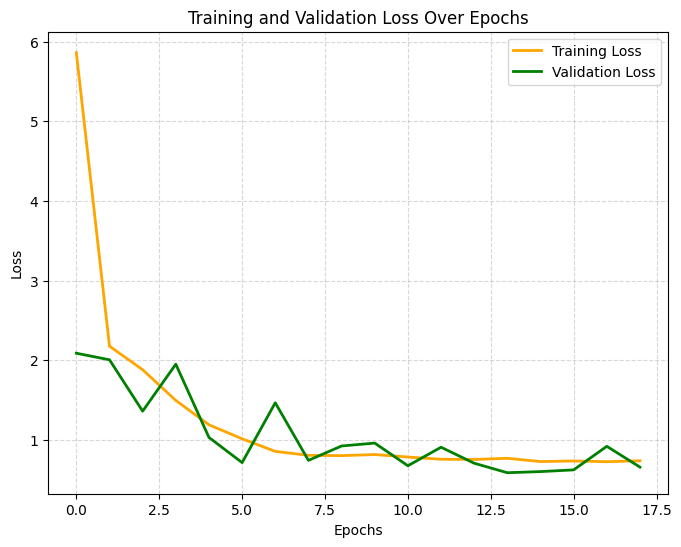

In [22]:
space = np.arange(0, 18)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(space, train_loss_list, color='orange', label='Training Loss', linewidth=2)
ax.plot(space, test_loss_list, color='green', label='Validation Loss', linewidth=2)

ax.legend()

ax.grid(True, linestyle='--', alpha=0.5)

ax.set_title('Training and Validation Loss Over Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

In [18]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/model_cnnlstm_final.pth')

loaded_model = CNNLSTM()
loaded_model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/model_cnnlstm.pth'))

<All keys matched successfully>

In [19]:
torch.cuda.memory_allocated()

912591360

## **Test the model**

- Using the data on the test set to predict, it is found that the real value is very close to the predicted value.

In [20]:
loaded_model =loaded_model.to(device)

predictions = []
real = []
for i in range(len(test_dataset)):
  x = test_dataset[i][0]
  x = x.view(-1, 10, 3, 128, 128).to(device)
  w = test_dataset[i][1].view(1,9).to(device)
  pr = loaded_model(x, w).squeeze().item()
  r = test_dataset[i][2]
  predictions.append(pr)
  real.append(r)

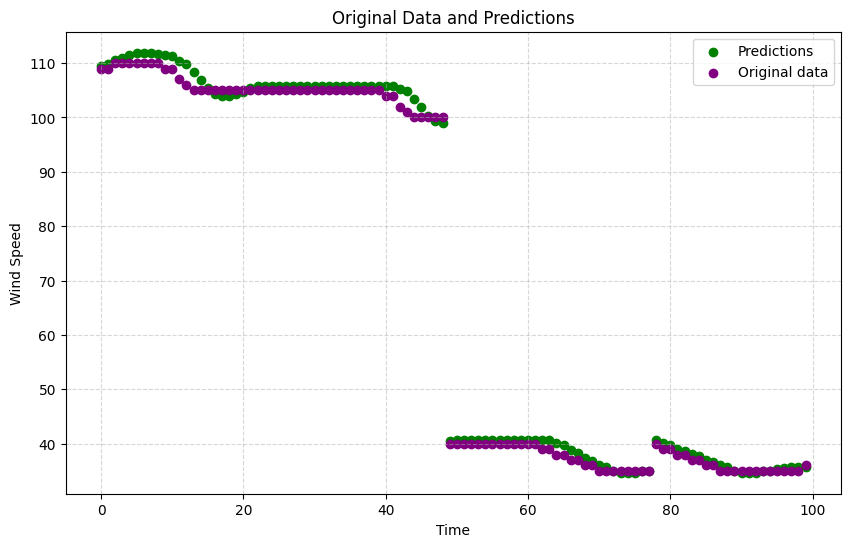

In [21]:
import numpy as np

space = np.arange(0,100)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(space, predictions[0:100], color='green', marker='o', linestyle='-', label='Predictions')
ax.scatter(space, real[0:100], color='purple', marker='o', linestyle='-', label='Original data')

ax.legend()

ax.grid(True, linestyle='--', alpha=0.5)

ax.set_title('Original Data and Predictions')
ax.set_xlabel('Time')
ax.set_ylabel('Wind Speed')


plt.show()


This result shows that the prediction results are lagging behind, but the overall performance is still good, which is the problem of weight imbalance we just mentioned. Next, we directly use CNN to predict without considering the correlation between time.

# CNN

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd ./gdrive/MyDrive/gp2

Mounted at /content/gdrive/
/content/gdrive/MyDrive/gp2


In [ ]:
!pip install pycm livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
class Storm_Dataset(Dataset):
    """
    A custom dataset class for loading image data along with their associated
    labels and features.

    This class is designed to load data from a specified directory, handling
    images and their associated
    label and feature files. It splits the data into training and test sets
    and supports basic transformations.

    Attributes:
        root (str): The root directory from which the data is loaded.
        data (list): List of tuples containing paths to images and their
        associated labels and features.
        train_data (list): List of training data samples.
        test_data (list): List of test data samples.

    Args:
        root (str): The directory path from where to load the data.
        test_size (float, optional): Proportion of the dataset to include in
        the test split. Defaults to 0.2.
        seed (int, optional): Random seed for splitting the dataset.
        Defaults to 42.
    """

    def __init__(self, root,
                 test_size=0.2, seed=42, split_method='random', split='none'):
        self.root = root
        all_data = self._get_image_paths()
        self.data = all_data
        # Splitting the dataset into training and testing
        # Also allows for no split for data analysis
        if split_method == 'random':
            train, test = train_test_split(
                all_data, test_size=test_size, random_state=seed)
            if split == 'train':
                self.data = train
            elif split == 'test':
                self.data = test
        elif split_method == 'time':
            split_index = math.floor(self.__len__() * 0.7)
            train = self.data[:split_index]
            test = self.data[split_index:]
            if split == 'train':
                self.data = train
            elif split == 'test':
                self.data = test

    def _get_image_paths(self, exts=(".jpg")):
        """
        Private method to scan the directory and gather image paths along with
        their label and feature data.

        This method walks through the directory, finds images with specified
        extensions, and attempts to locate corresponding label and feature
        files. It handles basic exceptions related to image loading.

        Args:
            exts (tuple of str, optional): File extensions to consider for
            images. Defaults to (".jpg").

        Returns:
            list: A list of tuples, each containing paths to an image, its
            label, and features.
        """
        data = []
        for root, dirs, files in os.walk(self.root):
            for file in files:
                if file.endswith(exts):
                    path = os.path.join(root, file)
                    num_path = path.removesuffix('.jpg')

                    try:
                        label_path = num_path + "_label.json"
                        features_path = num_path + "_features.json"
                        label, storm_id, time, ocean = None, None, None, None
                        if os.path.exists(label_path):
                            with open(label_path, 'r') as f:
                                label_data = json.load(f)
                                label = int(label_data['wind_speed'])

                        if os.path.exists(features_path):
                            with open(features_path, 'r') as f:
                                features_data = json.load(f)
                                storm_id = features_data['storm_id']
                                time = int(features_data['relative_time'])
                                ocean = int(features_data['ocean'])

                        data.append((path, label, storm_id, time, ocean))
                    except UnidentifiedImageError:
                        print('image error')
                        pass
        data.sort(key=itemgetter(3))
        return data

    def __getitem__(self, idx):
        """
        Returns a single data sample at the specified index.

        This method reads the image from the disk, applies transformations if
        required, and returns it along with its label and features.

        Args:
            idx (int): The index of the data sample to retrieve.

        Returns:
            tuple: A tuple containing the transformed image, label, and
            features of the sample.
        """
        img_path, label,  storm_id, time, ocean = self.data[idx]
        img = Image.open(img_path)
        img = img.convert('L')
        img = ToTensor()(img)
        img = Resize((256,256))(img)
        return img, label

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.data)

    def __str__(self):
        """
        Returns a string representation of the dataset object.

        Provides a summary of the dataset including its length and other
        attributes except the raw data.

        Returns:
            str: A string summarizing the dataset.
        """
        class_string = self.__class__.__name__
        class_string += f"\n\tlen : {self.__len__()}"
        for key, value in self.__dict__.items():
            if key != "data":
                class_string += f"\n\t{key} : {value}"
        return class_string

## CNN - use image difference

Following the idea of LSTM, we tried to embed the idea of time series in our CNN model. The first model we tried is to input image difference and output wind speed, where the image difference is:

In [ ]:
ds = Storm_Dataset('/content/gdrive/MyDrive/gp2/Selected_Storms_curated/bkh')

In [ ]:
numpy_image_0 = torch.squeeze(ds[0][0]).numpy()
numpy_image_1 = torch.squeeze(ds[1][0]).numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


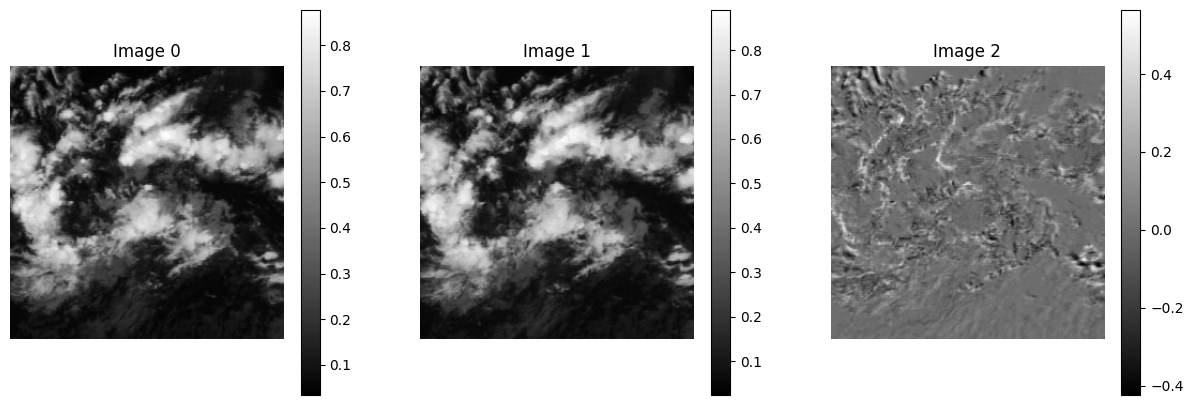

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # figsize can be adjusted as needed

# Plot first image
axs[0].imshow(numpy_image_0, cmap='gray')
axs[0].axis('off')  # To hide the axis
axs[0].set_title('Image 0')
fig.colorbar(axs[0].imshow(numpy_image_0, cmap='gray'), ax=axs[0], orientation='vertical')

# Plot second image
axs[1].imshow(numpy_image_1, cmap='gray')
axs[1].axis('off')  # To hide the axis
axs[1].set_title('Image 1')
fig.colorbar(axs[1].imshow(numpy_image_1, cmap='gray'), ax=axs[1], orientation='vertical')

# Plot third image
axs[2].imshow(numpy_image_1 - numpy_image_0, cmap='gray')  # Assuming numpy_image_3 was a typo
axs[2].axis('off')  # To hide the axis
axs[2].set_title('Image 2')
fig.colorbar(axs[2].imshow(numpy_image_1 - numpy_image_0, cmap='gray'), ax=axs[2], orientation='vertical')

# Display the plot
plt.show()

The third image is the difference of the first two, which have a half hour difference. The grey pixels in the difference image show that no change occurs, whereas the white and black pixels show the cloud has moved. From this observation, we may assume that more the white/black pixels, the wind speed is higher. Therefore, I tried a network that takes the difference image of two adjancent images and output the speed of later image.

However, the results is not good. This is because the difference image has very small intensity (about 0.01), but the speed is about 50. This makes the network difficult to train even I tried to scale the speed.

## CNN - use relative speed and multi-channel images

To make the differencing process more generalized, I tried to concat 3 adjacent images to a 3 channel image. By passing the 3 channel image to CNN, CNN is expected to learn the relation among these images. Besides the changes I made for input data, I also change the label to use. The label used here is not the absolute speed of the last image, but the speed difference of the last one and the first image. The CNN model is then expected to learn how speed changes with respect to how storm images change.

I first to try a CNN regression model to predict, but the predicting values are mostly around 0.12 even the real speed change is 4. This is because most of the speed change is 0, and the network learn this pattern instead of learn speed change from image change. To address this problem, I tried to treat this problem as classification instead of regression. After EDA, I find the speed change ranges from -4 to 5, which is considered as 10 classes in my model. However, the model is very easy to overfit even I used 15 stroms of data, where training set accuracy is about 0.95, but the validation accuracy is about 0.5.

## CNN - a simple model

After several trials to include time series to CNN and find it hard to train, I decided to use the most simple one which simply takes a grey image and predicts its speed.  

In [ ]:
class ImageRegressionCNN(nn.Module):
    def __init__(self):
        super(ImageRegressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.LeakyReLU(0.2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2_5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.LeakyReLU(0.2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        # Calculate the correct input size
        self.fc1_input_size = 64 * 64 * 64
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)


    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.act2(self.conv2_5(x))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.flatten(x)
        x = self.act2(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(self.act3(x))
        return x

This CNN architecture contains only three conv layer, two pooling layers, and two linear layers to output a single scaler as wind speed. LeakyReLU is used to help the training loss decreas, which is a major problem met in above time series cnn problems.

In [ ]:
storm_list=['hig', 'gme', 'woc', 'blq', 'kqu', 'wsy', 'ipa', 'ztb', 'qpq', 'pjj']

Instead of working on a single storm set or all storm sets, we choose ten storms from a same ocean (ocean 1). This is because the speed distribution is very different for different ocean.

In [ ]:
import StormForcast

In [ ]:
cnn_model = StormForcast.Train_Validate('/content/gdrive/MyDrive/gp2/Selected_Storms_curated/', task='WindSpeed', device='cuda',
                                        batch_size_train=32, batch_size_val=1000, batch_size_test=1000,
                                        lr=2e-3, epoch=20, split_method='random', num_storms=10)

setting basic parameters ......
done
setting hyperparameters ......
done
initializing model, optimier, criterion ......
done
loading data ......


Loading Data:  97%|█████████▋| 2962/3050 [01:01<00:01, 48.40it/s] 
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


done


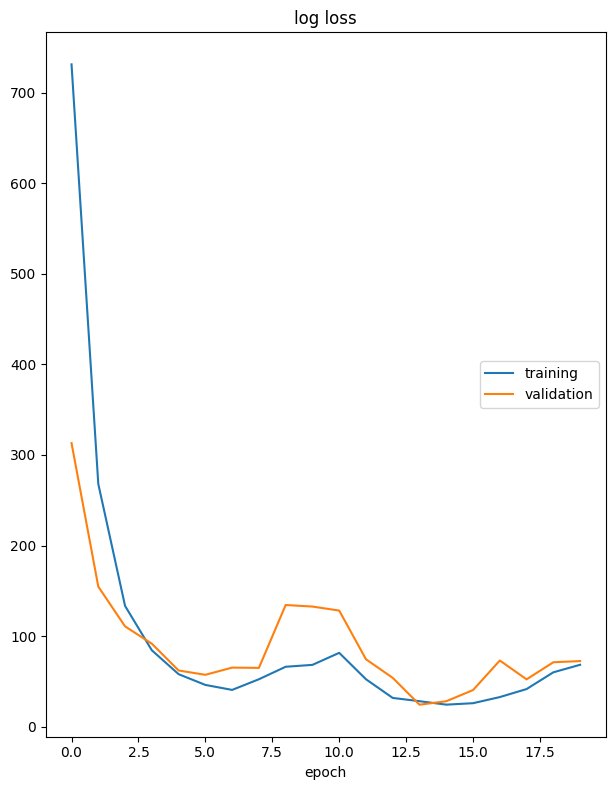

log loss
	training         	 (min:   24.160, max:  731.634, cur:   68.222)
	validation       	 (min:   24.095, max:  313.141, cur:   72.313)


In [ ]:
cnn_model.train_whole()

The loss curve shows the minimum MSE loss during training is about 24 (i.e. absolute difference is about 5). Although the difference between train loss and val loss is small, it can not show that the model really have good generalization, as will be discussed in the next section.

### Temporal Linearity Considerations

Because adjacent data points in time (storm image and speed) has strong correlation, if we devide train and val datasets randomly, these two set may not be independent. This can cause the validation loss not trustable.

To resolve this problem, when we are dealing with the surprise storm dataset, we devided the labeled part according to time (i.e. img 0-220 is trainset, img 220-241 is val set). This can reduce the dependencies between them as much as possible.

In [ ]:
torch.save({'model_state_dict': cnn_model.model.state_dict(),
            'optimizer_state_dict': cnn_model.optimizer.state_dict(),
            }, 'general_model.pth')

In [ ]:
surprise_model = StormForcast.Train_Validate('./tst/tst', task='WindSpeed', device='cuda',
                                        batch_size_train=32, batch_size_val=100, batch_size_test=100,
                                        lr=2e-8, epoch=50, split_method='random', num_storms=3, surprise_storm=True,
                                        resume=True, resume_path='general_model.pth')

setting basic parameters ......
done
setting hyperparameters ......
done
initializing model, optimier, criterion ......
done
resuming previous model ......
done
loading data ......


Loading Data:  84%|████████▎ | 255/305 [00:04<00:00, 57.97it/s] 

done


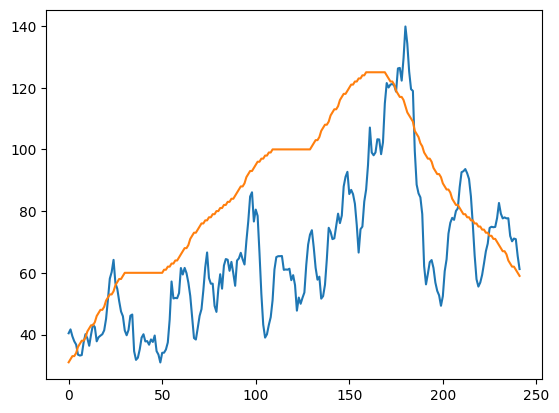

In [ ]:
surprise_model.draw_result()

This is how the trained model (with 10 storms) predict the entire surprise storm (as test set)

We then try to do transfer learning on this dataset (trainset and valset are temporally splitted)

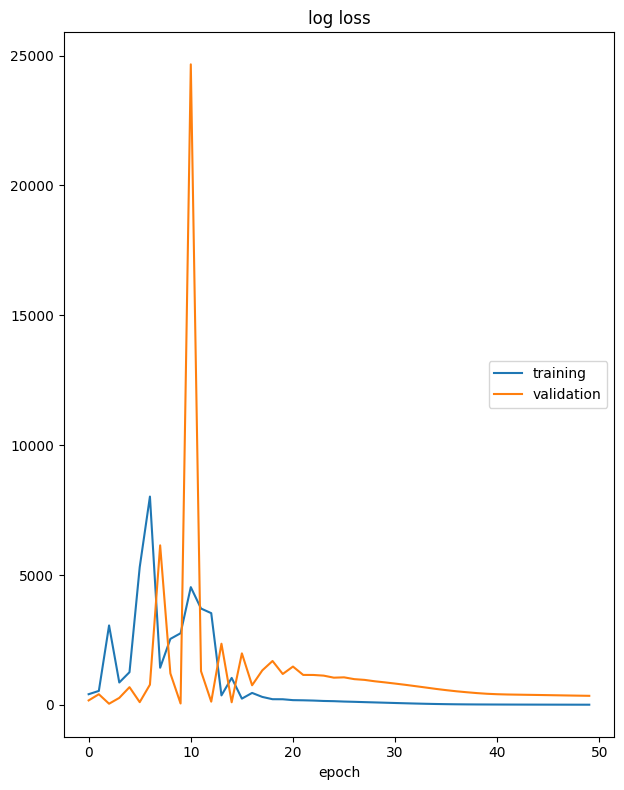

log loss
	training         	 (min:    9.412, max: 8022.571, cur:    9.412)
	validation       	 (min:   46.862, max: 24662.961, cur:  351.271)


In [ ]:
surprise_model.train_whole()

The loss curves show the model is terribly overfitting, this is also implied on the prediction below, where the predicted value for validation is increasing.

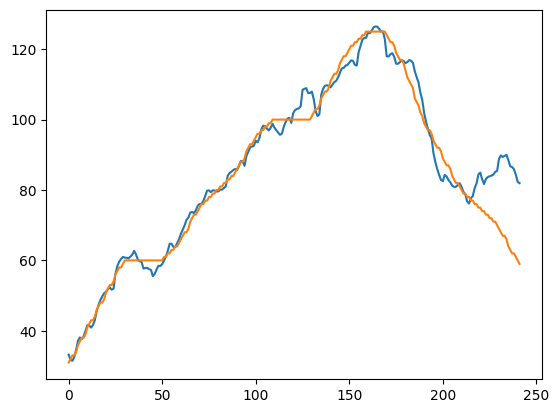

In [ ]:
surprise_model.draw_result()

After properly adjust the weight_decay, batch_size, and learning rate, we successfully make the validation loss as small as we can.

setting basic parameters ......
done
setting hyperparameters ......
done
initializing model, optimier, criterion ......
done
resuming previous model ......
done
loading data ......


Loading Data:  84%|████████▎ | 255/305 [00:04<00:00, 57.93it/s] 


done
[61.238800048828125, 59.23664093017578, 57.165714263916016, 54.888301849365234, 55.88120651245117, 56.282752990722656, 55.752403259277344, 54.44566345214844, 51.31209182739258, 50.20683288574219, 61.59809112548828, 60.203372955322266, 60.65337371826172]


[61.238800048828125,
 59.23664093017578,
 57.165714263916016,
 54.888301849365234,
 55.88120651245117,
 56.282752990722656,
 55.752403259277344,
 54.44566345214844,
 51.31209182739258,
 50.20683288574219,
 61.59809112548828,
 60.203372955322266,
 60.65337371826172]

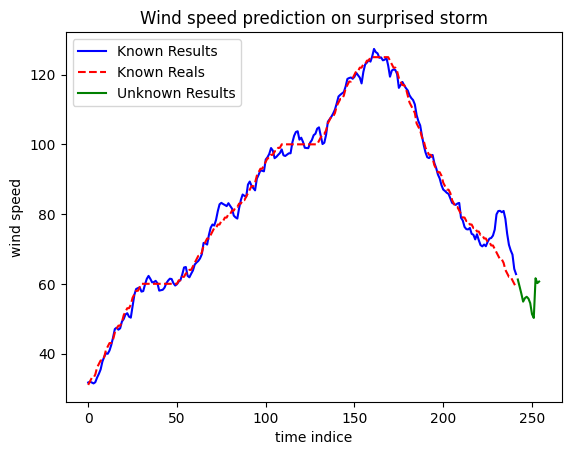

In [ ]:
surprise_model = StormForcast.Train_Validate('./tst/tst', task='WindSpeed', device='cuda',
                                        batch_size_train=135, batch_size_val=100, batch_size_test=100,
                                        lr=2e-11, epoch=30, weight_decay=1e-1, split_method='random', num_storms=1, surprise_storm=True,
                                    resume=True, resume_path='CNNGeneral_epoch_22__2024-02-02_06-01-14.pth')
surprise_model.draw_result(type='predict')
surprise_model.predict()

This is the final model we use, where the prediction for validation is now decreasing.